In [1]:
print("Hello worldo!")

Hello worldo!


In [2]:
# TODO:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model and batch: .to(device)

In [3]:
from __future__ import annotations
import typing

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(3654)

In [370]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# report the parameters | and loss with 5k training steps:

# bigram model: 3844 ==> loss to 2.5
# with one multihead attention (5 heads): 53262 ==> loss to 0.35
# with one multihead attention (5 heads) and residual connection: 53262 ==> loss to 0.30
# with one full block: 134162 ==> loss to 0.24

### Get text data

In [5]:
with open("text_corpus.txt", encoding="utf-8") as f:
    text = f.read()[:10_000]

In [6]:
vocab = sorted(set(text))
print(vocab)

['\n', ' ', '%', "'", ',', '.', '0', '1', '2', '3', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
vocab_size = len(vocab)
vocab_size

62

### Encode the characters to integers

In [8]:
# Create encoder and decoder dicts

char_int_mapping = dict()
int_char_mapping = dict()

for i, c in enumerate(sorted(set(text))):
    char_int_mapping[c] = i
    int_char_mapping[i] = c

In [9]:
# examples
print(char_int_mapping["g"])
print(int_char_mapping[42])

42
g


In [10]:
def encode(string: str) -> List[int]:
    int_list = [char_int_mapping[char] for char in string]
    return int_list

def decode(int_list: List[int]) -> str:
    string = [int_char_mapping[num] for num in int_list]
    return "".join(string)

In [11]:
# examples
print(encode("hellooo"))
print(decode([43, 40, 47, 47, 50, 50, 50]))

[43, 40, 47, 47, 50, 50, 50]
hellooo


In [12]:
encode("hello world")

[43, 40, 47, 47, 50, 1, 58, 50, 53, 47, 39]

### Make it a tensor

In [13]:
data = torch.tensor(encode(text), dtype=torch.long)
data.shape

torch.Size([10000])

### Train/Test split

In [14]:
len(data)

10000

In [15]:
N = int(0.9*len(data))
train_data = data[:N]
test_data = data[N:]

print(len(train_data), len(test_data))

9000 1000


### Create minibatches

In [16]:
block_size = 8 # block_size is the maximum context length (input textblock size)
batch_size = 4

In [17]:
train_data[:block_size]

tensor([ 1, 53, 40, 48, 40, 48, 37, 40])

In [18]:
def get_batch(split: torch.tensor):
    offsets = np.random.randint(0, len(split) - batch_size, size=batch_size)
    x = torch.stack([split[i:i+block_size] for i in offsets])
    y = torch.stack([split[i+1:i+block_size+1] for i in offsets])
    return x, y

In [19]:
xb, yb = get_batch(train_data)
xb

tensor([[44, 49, 42,  1, 47, 44, 46, 40],
        [49, 42,  1, 50, 41,  1, 58, 44],
        [49, 42,  1, 36, 49, 55, 44, 37],
        [54, 56, 51, 51, 50, 53, 55, 54]])

In [20]:
yb

tensor([[49, 42,  1, 47, 44, 46, 40,  1],
        [42,  1, 50, 41,  1, 58, 44, 49],
        [42,  1, 36, 49, 55, 44, 37, 44],
        [56, 51, 51, 50, 53, 55, 54,  1]])

In [21]:
decode(xb[3].tolist())

'supports'

In [22]:
for b in range(batch_size):
    print(f"----- BATCH {b} -----")
    
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f"context: {decode(context.tolist())} -> target: {decode([int(target)])}")
    print()
        
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f"context: {context.tolist()} -> target: {int(target)}")
    print()

----- BATCH 0 -----
context: i -> target: n
context: in -> target: g
context: ing -> target:  
context: ing  -> target: l
context: ing l -> target: i
context: ing li -> target: k
context: ing lik -> target: e
context: ing like -> target:  

context: [44] -> target: 49
context: [44, 49] -> target: 42
context: [44, 49, 42] -> target: 1
context: [44, 49, 42, 1] -> target: 47
context: [44, 49, 42, 1, 47] -> target: 44
context: [44, 49, 42, 1, 47, 44] -> target: 46
context: [44, 49, 42, 1, 47, 44, 46] -> target: 40
context: [44, 49, 42, 1, 47, 44, 46, 40] -> target: 1

----- BATCH 1 -----
context: n -> target: g
context: ng -> target:  
context: ng  -> target: o
context: ng o -> target: f
context: ng of -> target:  
context: ng of  -> target: w
context: ng of w -> target: i
context: ng of wi -> target: n

context: [49] -> target: 42
context: [49, 42] -> target: 1
context: [49, 42, 1] -> target: 50
context: [49, 42, 1, 50] -> target: 41
context: [49, 42, 1, 50, 41] -> target: 1
context: [49,

### Create a simple model

In [23]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, context, targets):
        logits = self.token_embedding_table(context) # (Batch, Time, Channels) ==> [4, 8, 62]

        B, T, C = logits.shape
        logits = logits.view(B*T,C) # [32,64]
        targets = targets.view(B*T) # [32]
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, context, max_new_tokens):
        
        # context: (Batch, Time) ==> [4, 8]
        # -> extend context in Time dimension for max_new_tokens
        
        for _ in range(max_new_tokens):
            
            # get prediction
            logits, loss = self(xb, yb)
            
            # get logits for the last character 
            # (because we only need the last char to predict with our bigram model)
            logits = logits.view(batch_size,-1,vocab_size) # (B,T,C)
            logits = logits[:, -1, :] # (B,C) for only the last character
            
            probs = F.softmax(logits, dim=-1) # (B,C)
            next_token = torch.multinomial(probs, num_samples=1) # (B,1)
            
            # append next token to the sequence
            context = torch.cat((context, next_token), dim=1) # (B,T+1)
        
        return context
    
    def generate_to_text(self, context, max_new_tokens):
        context = self.generate(context, max_new_tokens)
        return decode(context[0].tolist())

model = BigramLanguageModel(vocab_size)
model

BigramLanguageModel(
  (token_embedding_table): Embedding(62, 62)
)

In [24]:
count_trainable_parameters(model)

3844

### Train the simple model

In [49]:
batch_size = 32
losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for step in range(5_000):
    
    # get a batch
    xb, yb = get_batch(train_data)
    
    # predict and get loss
    logits, loss = model(xb, yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

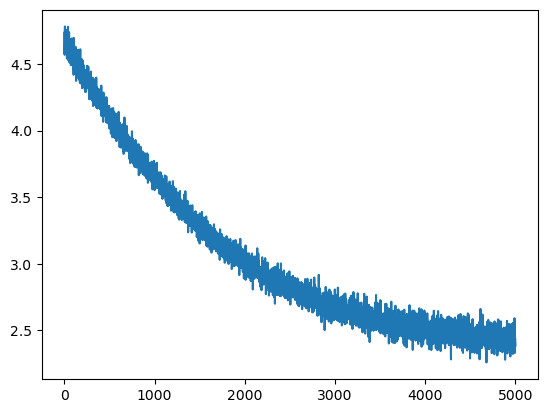

In [27]:
plt.plot(losses)

In [28]:
# inference
zero_context = torch.zeros((batch_size,1))
model.generate_to_text(zero_context, max_new_tokens=200)

'\nanhiaah  a,,o aoia\niW,ana heBhahio ahahaahaohoahiaahaaa  ahiataaih,ei,aiaohot2e, aia ahEinho,hoeAao o  eoiatenhehhai ioaaaheeo hhaa?ohjee,?h,2W?hai hhaioyoioYoh?oah.hh o,e,Ooehx aaoahahhepaixannaohiae'

### Attention

In [29]:
Q = torch.rand(5,1)
K = torch.rand(5,1)
V = torch.rand(5,1)
Q,K,V

(tensor([[0.5499],
         [0.5899],
         [0.8726],
         [0.8996],
         [0.7301]]),
 tensor([[0.4520],
         [0.8163],
         [0.5874],
         [0.7089],
         [0.1228]]),
 tensor([[0.8152],
         [0.7577],
         [0.0832],
         [0.2580],
         [0.2888]]))

In [30]:
def attention(Q,K,V):
    """ 
    Applies masked scaled dot-product attention
    between vectors of queries Q, keys K and values V. 
    """
    d_k = torch.tensor(Q.shape[0])
    W = (Q @ K.T) / torch.sqrt(d_k)
    
    # mask out forbidden connections
    tril = torch.tril(torch.ones((d_k, d_k)))
    W = W.masked_fill(tril==0, float("-inf"))
    
    W = F.softmax(W, dim=1)
    
    return W @ V

In [31]:
attention(Q,K,V)

tensor([[0.8152],
        [0.7851],
        [0.5539],
        [0.4780],
        [0.4451]])

### Multi-Head Attention

In [32]:
def multi_head_attention(Q,K,V):
    d_k = torch.tensor(Q.shape[0])
    d_model = 8 # project in to this space
    N_heads = 2
    
    # linear layers
    projections = {
        x: {
            h: nn.Linear(d_k, d_model, bias=False) for h in range(N_heads)
        } for x in ["Q", "K", "V"]
    }
    
    # layer to combine the concatenated attention-block output vectors
    top_layer = nn.Linear(N_heads * d_model, d_k, bias=False)
    
    # forward pass
    result = torch.zeros(N_heads, d_model, 1)

    for h in range(N_heads):
        result[h] = attention(
            projections["Q"][h](Q.T).T,
            projections["K"][h](K.T).T,
            projections["V"][h](V.T).T
        )
    
    concat_attn_out = result.view(1, N_heads * d_model)
    return top_layer(concat_attn_out).T

In [33]:
multi_head_attention(Q,K,V)

tensor([[-0.0503],
        [ 0.0417],
        [ 0.0317],
        [ 0.0227],
        [-0.0685]], grad_fn=<PermuteBackward0>)

In [34]:
d_k = torch.tensor(Q.shape[0])
d_model = 8 # project in to this space
N_heads = 2

projections = {
    x: {
        h: nn.Linear(d_k, d_model, bias=False) for h in range(N_heads)
    } for x in ["Q", "K", "V"]
}

projections

{'Q': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)},
 'K': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)},
 'V': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)}}

In [35]:
projections["Q"][0](Q.T).T

tensor([[-0.1686],
        [-0.4816],
        [ 0.1033],
        [-0.3457],
        [-0.7313],
        [-0.2949],
        [ 0.2788],
        [ 0.2492]], grad_fn=<PermuteBackward0>)

In [36]:
attention(Q,K,V)

tensor([[0.8152],
        [0.7851],
        [0.5539],
        [0.4780],
        [0.4451]])

In [37]:
result = torch.zeros(N_heads, d_model, 1)

for h in range(N_heads):
    result[h] = attention(
        projections["Q"][h](Q.T).T,
        projections["K"][h](K.T).T,
        projections["V"][h](V.T).T
    )

In [38]:
result

tensor([[[-0.2149],
         [-0.0779],
         [-0.1218],
         [-0.0631],
         [ 0.0309],
         [ 0.0585],
         [ 0.0468],
         [ 0.0262]],

        [[ 0.2127],
         [ 0.1708],
         [-0.0117],
         [ 0.0307],
         [-0.0344],
         [-0.0028],
         [ 0.0865],
         [ 0.1064]]], grad_fn=<CopySlices>)

In [39]:
concat_attn_out = result.view(1, N_heads * d_model)
concat_attn_out

tensor([[-0.2149, -0.0779, -0.1218, -0.0631,  0.0309,  0.0585,  0.0468,  0.0262,
          0.2127,  0.1708, -0.0117,  0.0307, -0.0344, -0.0028,  0.0865,  0.1064]],
       grad_fn=<ViewBackward0>)

In [40]:
top_layer = nn.Linear(N_heads * d_model, d_k, bias=False)

In [41]:
top_layer(concat_attn_out).T.shape

torch.Size([5, 1])

### Masking

In [42]:
T = 10
tril = torch.tril(torch.ones((T,T)))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

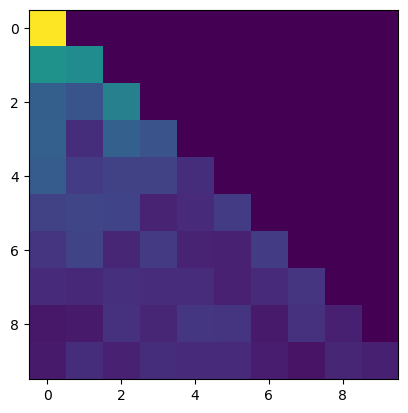

In [43]:
W = torch.rand((T,T)) # there will be real data here

# mask out forbidden connections
W = W.masked_fill(tril==0, float("-inf")) # set everywhere where tril is 0 to -inf (upper right)

W = F.softmax(W, dim=-1)
plt.imshow(W)

### Positional encoding

- learned

### Transformer

In [181]:
# hyperparameters
embed_dims = 100 # is equivalent to d_model
block_size = 8
batch_size = 32
n_heads = 5
head_size = embed_dims // n_heads

In [290]:
class SelfAttentionHead(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.proj_q = nn.Linear(embed_dims, head_size, bias=False)
        self.proj_k = nn.Linear(embed_dims, head_size, bias=False)
        self.proj_v = nn.Linear(embed_dims, head_size, bias=False)
    
    def forward(self, x):
        """ 
        Applies masked scaled dot-product attention
        between vectors of queries Q, keys K and values V. 
        """
        Q = self.proj_q(x)
        K = self.proj_k(x)
        V = self.proj_v(x)

        W = (Q @ K.transpose(-1,-2)) # (B, T, C) @ (B, C, T) ==> (B,T,T)
        W /= torch.sqrt(torch.tensor(head_size))
        
        # mask out forbidden connections
        tril = torch.tril(torch.ones((block_size, block_size)))
        W = W.masked_fill(tril==0, float("-inf"))
        W = F.softmax(W, dim=1)
        out = W @ V
        return out # (B,T,C=head_size)

In [291]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.heads = nn.ModuleList([SelfAttentionHead() for i in range(n_heads)])
        self.proj = nn.Linear(embed_dims, embed_dims, bias=False) # embed_dims = n_heads * head_size
    
    def forward(self, x):
        
        out = torch.cat([attn_head(x) for attn_head in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [357]:
class Block(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention()
        self.ln1 = nn.LayerNorm(embed_dims)
        self.ln2 = nn.LayerNorm(embed_dims)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dims, 4*embed_dims), # following attention-is-all-you-need paper for num hidden units
            nn.ReLU(),
            nn.Linear(4*embed_dims, embed_dims),
            nn.ReLU(),
        )
    
    def forward(self, x):
        
        # Applies layernorm before self-attention.
        # In the attention-is-all-you-need paper they apply it afterwards, 
        # but apparently pre-ln performs better. pre-ln paper: https://arxiv.org/pdf/2002.04745.pdf
        
        x = x + self.attn(self.ln1(x)) # (B,embed_dims)
        x = x + self.mlp(self.ln2(x))
        return x

In [363]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dims)
        
        # positional encoding
        self.pos_embedding_table = nn.Embedding(block_size, embed_dims)
        
        # transformer layers
        # self.multihead_attn1 = MultiHeadAttention()
        self.block1 = Block()
        
        # output layers
        self.lm_head = nn.Linear(embed_dims, vocab_size)
        
    
    def forward(self, context, targets):
        
        B, T = context.shape
        
        # get the embedding vectors word-to-vec style
        token_emb = self.token_embedding_table(context) # (Batch, Time, Channels) ==> [4, 8, 62]
        
        # add the positional embedding'
        pos_emb = self.pos_embedding_table(torch.arange(T)) # (T,C)
        
        x = token_emb + pos_emb

        # transformer stuff
        # x = self.multihead_attn1(x)
        x = self.block1(x)

        # output layers
        logits = self.lm_head(x)        
        
        
        B, T, C = logits.shape
        logits = logits.view(B*T,C) # [32,64]
        targets = targets.view(B*T) # [32]
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, context, max_new_tokens):
        
        
        # context: (Batch, Time) ==> [4, 8]
        # -> extend context in Time dimension for max_new_tokens
        
        for _ in range(max_new_tokens):
            
            # get prediction
            logits, loss = self(xb, yb)
            
            # get logits for the last character 
            # (because we only need the last char to predict with our bigram model)
            logits = logits.view(batch_size,-1,vocab_size) # (B,T,C)
            logits = logits[:, -1, :] # (B,C) for only the last character
            
            probs = F.softmax(logits, dim=-1) # (B,C)
            next_token = torch.multinomial(probs, num_samples=1) # (B,1)
            
            # append next token to the sequence
            context = torch.cat((context, next_token), dim=1) # (B,T+1)
        
        return context
    
    def generate_to_text(self, context, max_new_tokens):
        context = self.generate(context, max_new_tokens)
        return decode(context[0].tolist())

model = BigramLanguageModel(vocab_size)
model

BigramLanguageModel(
  (token_embedding_table): Embedding(62, 100)
  (pos_embedding_table): Embedding(8, 100)
  (block1): Block(
    (attn): MultiHeadAttention(
      (heads): ModuleList(
        (0): SelfAttentionHead(
          (proj_q): Linear(in_features=100, out_features=20, bias=False)
          (proj_k): Linear(in_features=100, out_features=20, bias=False)
          (proj_v): Linear(in_features=100, out_features=20, bias=False)
        )
        (1): SelfAttentionHead(
          (proj_q): Linear(in_features=100, out_features=20, bias=False)
          (proj_k): Linear(in_features=100, out_features=20, bias=False)
          (proj_v): Linear(in_features=100, out_features=20, bias=False)
        )
        (2): SelfAttentionHead(
          (proj_q): Linear(in_features=100, out_features=20, bias=False)
          (proj_k): Linear(in_features=100, out_features=20, bias=False)
          (proj_v): Linear(in_features=100, out_features=20, bias=False)
        )
        (3): SelfAttentionHea

In [368]:
losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 3e-4

for step in range(100):
    
    # get a batch
    xb, yb = get_batch(train_data)
    
    # predict and get loss
    logits, loss = model(xb, yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

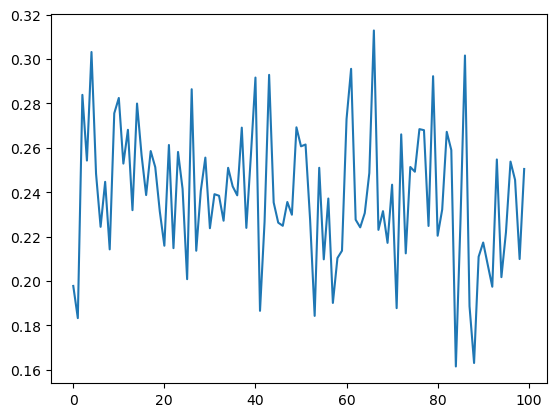

In [369]:
plt.plot(losses)

In [377]:
# inference
zero_context = torch.zeros((batch_size,1))
xb, yb = get_batch(train_data)
model.generate_to_text(xb, max_new_tokens=200)

' contriblaolauuelolleululleulualaielaloluunilalillululaaoullliloieia lllaalllaiilliloliluuuulliualllllllllllieuluueiloaualeillloelialleoilluiouuuillnilllululrluuuiolnllelallulilaelllelliuillaualilaliiulllluou'

In [367]:
count_trainable_parameters(model)

134162